In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from arcs.generate import GraphGenerator

In [48]:
graph = GraphGenerator().from_file(filename='../tests/test_dft_data.json',temperature=100,pressure=1)

In [49]:
from monty.serialization import loadfn 

data = loadfn('../tests/test_dft_data.json')

reactions = data['reactions']

In [53]:
reactions['27']

{'reaction_string': '1 H2O + 1 CH3CH2OH = 2 CH3OH',
 'reactants': {'H2O': 1, 'CH3CH2OH': 1},
 'products': {'CH3OH': 2}}

In [55]:
graph.nodes[1]

{'reaction': {'reaction_string': '2 H2O = 1 O2 + 2 H2',
  'reactants': {'H2O': 2},
  'products': {'O2': 1, 'H2': 2}}}

In [ ]:
nx.shortest_path(graph,'H2','H2SO4')

['H2O', 1, 'O2']

In [ ]:
graph.nodes[0]

{'reaction': {'reaction_string': '2 H2O + 1 CO = 1 O2 + 1 CH3OH',
  'reactants': {'H2O': 2, 'CO': 1},
  'products': {'O2': 1, 'CH3OH': 1}}}

/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


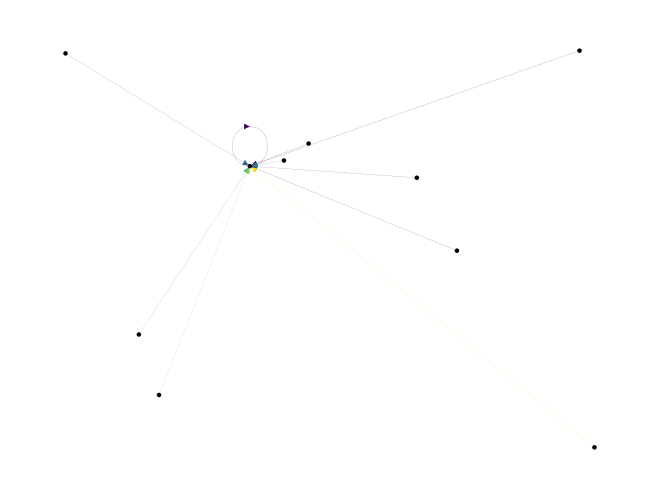

In [27]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
G = graph 

node_colours= []
node_sizes = []
for node in list(G.nodes):
    if isinstance(node,int):
        node_colours.append('black')
        node_sizes.append(5)
    else:
        node_colours.append('white')
        node_sizes.append(100)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
vmin = np.min(weights)
vmax = np.max(weights)
cmap = plt.cm.viridis

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,edge_color=weights,width=0.1,edge_cmap=cmap,vmin=vmin,vmax=vmax)